## Assignment 3 - Decision Tree

### Objective:

To classify breast cancer patients as "Alive" or "Dead" based on their characteristics using a decision tree model.

### Dataset:

This dataset comprises information on female breast cancer patients diagnosed between 2006 and 2010 with infiltrating duct and lobular carcinoma of the breast. The data was obtained from the SEER Program's November 2017 update.

**Input Variables:**

- **Age:** Age of the patient
- **Race:** Patient's race
- **Marital Status:** Marital status of the patient
- **T Stage:** Adjusted AJCC 6th T stage classification for the tumor
- **N Stage:** Adjusted AJCC 6th N stage classification for regional lymph nodes
- **6th Stage:** Breast cancer adjusted AJCC 6th stage classification
- **Differentiate:** The degree of differentiation of the tumor
- **Grade:** The grade of the tumor, indicating its aggressiveness
- **A Stage:** Regional or Distant metastasis
- **Tumor Size:** Exact size of the tumor in millimeters
- **Estrogen Status:** Status of estrogen receptor in the tumor
- **Progesterone Status:** Status of progesterone receptor in the tumor
- **Regional Node Examined:** Number of regional lymph nodes examined
- **Regional Node Positive:** Number of regional lymph nodes positive for cancer
- **Survival Months:** Number of months the patient survived after diagnosis

### Output Variable:
**Status:** Dead/Alive

## Importing libraries and Reading the Dataset

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



#### Load Dataset

In [2]:

df = pd.read_csv('Breast_Cancer.csv')
df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


## Train, Validation, Test Split

In [3]:
train_df, test_df = train_test_split(df, test_size=0.25, random_state = 1)
train_df.shape, test_df.shape

((3018, 16), (1006, 16))

## Model Implementation

### Algorithm:
- Start with all examples at the root node
- Calculate gini impurity for splitting on all possible features and select the one with the lowest possible value
- Split the data according to the selected feature
- Repeat recursively until stopping criteria met.

### Gini Impurity
It is calculated for any feature as follows:
$$Gini\space Impurity\space (G) = 1 - \sum\limits_{}^{} p_{i}^2$$

Where \( $ p_i $ \) is the probability of an element being classified for a particular class.

### Gini Impurity of Node Split

**The Gini Impurity for a node split is calculated using the following formula:**

$$G_{\text{split}} = \frac{N_{\text{left}}}{N} G_{\text{left}} + \frac{N_{\text{right}}}{N} G_{\text{right}}$$

**Where:**
- \($ G_{\text{split}} $\) is the Gini Impurity of the split.
- \($ N_{\text{left}} $\) is the number of samples in the left child node.
- \($ N_{\text{right}} $\) is the number of samples in the right child node.
- \($ N $ \) is the total number of samples (i.e., \($ N = N_{\text{left}} + N_{\text{right}} $\)).
- \($ G_{\text{left}} $\) is the Gini Impurity of the left child node.
- \($ G_{\text{right}} $\) is the Gini Impurity of the right child node.

In [7]:
# Define a node class to represent the decision tree structure
class DTNode:
    def __init__(self, value):
        self.value = value
        self.children = {}

# Define the custom decision tree classifier
class DecisionTree:
    def __init__(self):
        self.root = DTNode(None)
        self.tree_depth = -1

    # Calculate potential splits for continuous features
    def find_splits(self, data, feature_idx, feature_name):
        continuous_features =  ['Age', 'Tumor Size', 'Reginol Node Positive', 'Regional Node Examined', 'Survival Months']

        if feature_name not in continuous_features:
            return []

        values_labels = data[:, [feature_idx, -1]]
        sorted_data = values_labels[values_labels[:, 0].argsort()]
        split_points = []

        for i in range(len(sorted_data) - 1):
            current_value = sorted_data[i][0]
            next_value = sorted_data[i + 1][0]

            if current_value != next_value:
                midpoint = (current_value + next_value) / 2
                split_points.append(midpoint)

        return split_points

    # Calculate the Gini impurity for a given dataset
    def compute_gini(self, data):
        labels = data[:, -1]
        _, label_counts = np.unique(labels, return_counts=True)
        probabilities = label_counts / label_counts.sum()
        gini_score = 1 - np.sum(np.square(probabilities))
        return gini_score

    # Determine the most common class for a given dataset (for leaf nodes)
    def majority_class(self, data):
        labels = data.iloc[:, -1]
        classes, counts = np.unique(labels, return_counts=True)
        return classes[np.argmax(counts)]

    # Create a leaf node when no further split is possible
    def create_leaf_node(self, data):
        classification = self.majority_class(data)
        gini = self.compute_gini(data.values)

        node_data = {
            "Node Type": "Leaf",
            "Class": classification,
            "Gini": gini,
            "Sample Count": data.shape[0]
        }
        return DTNode(node_data)

    # Recursive function to build the decision tree
    def build_tree(self, data, max_depth, available_features, current_depth):
        # Base case: all samples have the same class
        if len(np.unique(data.iloc[:, -1])) == 1:
            return self.create_leaf_node(data)

        # Base case: reached max depth or no more features to split
        if current_depth >= max_depth or len(available_features) == 0:
            return self.create_leaf_node(data)

        best_split = {"Feature": "", "Attribute": "", "Split_Point": None, "Best_Gini": float('inf')}

        for feature in available_features:
            col_idx = data.columns.get_loc(feature)
            potential_splits = self.find_splits(data.values, col_idx, feature)

            # For continuous features, find the optimal split
            if potential_splits:
                for split_value in potential_splits:
                    left_subset = data[data[feature] <= split_value]
                    right_subset = data[data[feature] > split_value]
                    gini_weighted = (
                        len(left_subset) * self.compute_gini(left_subset.values) +
                        len(right_subset) * self.compute_gini(right_subset.values)
                    ) / len(data)

                    if gini_weighted < best_split["Best_Gini"]:
                        best_split.update({
                            "Feature": feature,
                            "Attribute": col_idx,
                            "Split_Point": split_value,
                            "Best_Gini": gini_weighted
                        })
            # For categorical features, evaluate each unique value
            else:
                unique_vals = np.unique(data.iloc[:, col_idx])
                gini_accumulation = 0

                for val in unique_vals:
                    subset = data[data[feature] == val]
                    gini_val = self.compute_gini(subset.values)
                    gini_accumulation += (len(subset) / len(data)) * gini_val

                if gini_accumulation < best_split["Best_Gini"]:
                    best_split.update({
                        "Feature": feature,
                        "Attribute": col_idx,
                        "Split_Point": unique_vals,
                        "Best_Gini": gini_accumulation
                    })

        # Create a leaf if no valid split is found
        if best_split["Feature"] == "":
            return self.create_leaf_node(data)

        # Store node information and split recursively
        node_data = {
            "Feature": best_split["Feature"],
            "Gini": best_split["Best_Gini"],
            "Samples": data.shape[0],
            "Best_Split": best_split["Split_Point"]
        }
        node = DTNode(node_data)

        # Recursive splitting for continuous vs categorical features
        if best_split["Feature"] in  ['Age', 'Tumor Size', 'Reginol Node Positive', 'Regional Node Examined', 'Survival Months']:
            node.children["left"] = self.build_tree(data[data[best_split["Feature"]] <= best_split["Split_Point"]],
                                                    max_depth, available_features, current_depth + 1)
            node.children["right"] = self.build_tree(data[data[best_split["Feature"]] > best_split["Split_Point"]],
                                                     max_depth, available_features, current_depth + 1)
        else:
            for val in best_split["Split_Point"]:
                subset = data[data[best_split["Feature"]] == val]
                node.children[val] = self.build_tree(subset, max_depth, available_features, current_depth + 1)

        return node

    # Function to initiate model fitting
    def fit(self, data, max_depth=10):
        features = data.columns.tolist()[:-1]
        self.feature_names = np.array(features)
        self.root = self.build_tree(data, max_depth, features, 0)

   
    # Predict the class for a single data point
    def predict_single(self, data_point):
        node = self.root
        while "Class" not in node.value.keys():
            node_data = node.value
            if node_data["Feature"] in  ['Age', 'Tumor Size', 'Reginol Node Positive', 'Regional Node Examined', 'Survival Months']:
                if data_point[np.argwhere(self.feature_names == node_data["Feature"]).squeeze()] <= node_data["Best_Split"]:
                    node = node.children["left"]
                else:
                    node = node.children["right"]
            else:
                feature_val = data_point[np.argwhere(self.feature_names == node_data["Feature"]).squeeze()]
                node = node.children.get(feature_val, None)
                if node is None:
                    return -1

        return node.value["Class"]

    # Predict the class for multiple data points
    def predict(self, X):
        return np.array([self.predict_single(row) for row in X])
    



Test Accuracy for 1 : 90.85%
Test Accuracy for 2 : 90.85%
Test Accuracy for 3 : 91.15%
Test Accuracy for 4 : 91.25%
Test Accuracy for 5 : 90.85%
Test Accuracy for 6 : 89.36%
Test Accuracy for 7 : 89.26%
Test Accuracy for 8 : 88.57%
Test Accuracy for 9 : 87.87%
Test Accuracy for 10 : 87.18%
Test Accuracy for 11 : 86.28%
Test Accuracy for 12 : 85.49%
Test Accuracy for 13 : 85.29%
Test Accuracy for 14 : 84.99%
Test Accuracy for 15 : 84.89%
Test Accuracy for 16 : 84.79%
Test Accuracy for 17 : 84.79%
Test Accuracy for 18 : 84.79%
Test Accuracy for 19 : 84.79%
Test Accuracy for 20 : 84.79%
Maximum Accuracy is : 91.25% for epoch : 4


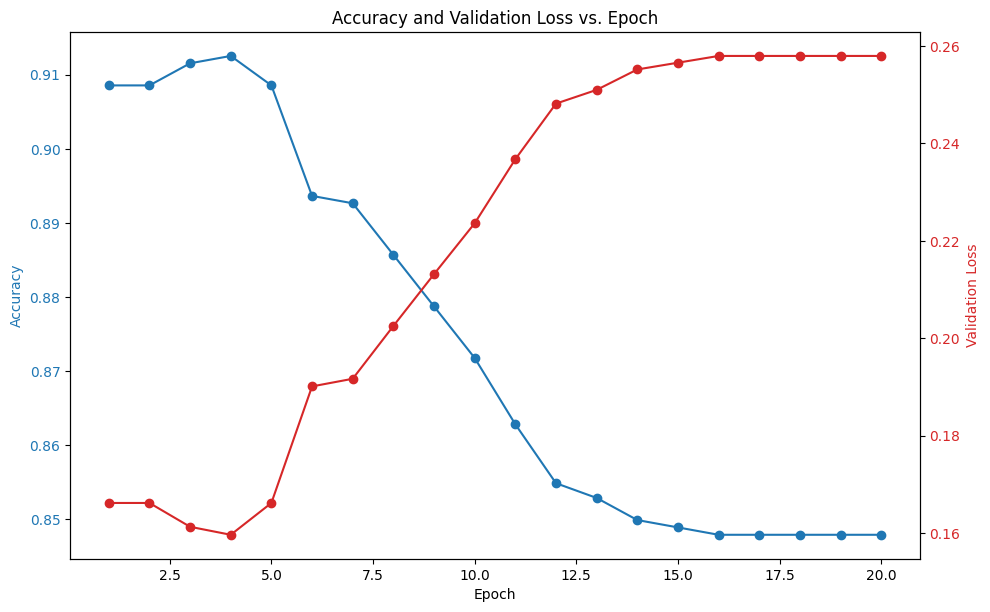

In [8]:


def epoch_fit():
    model = DecisionTree()
    best = 0
    best_accuracy = 0
    accuracies = []
    losses = []

    for epoch in range(1, 21):
        model.fit(train_df,epoch)

        X_test = test_df.values[:, :-1]
        Y_test = test_df.values[:, -1]

        Y_pred = model.predict(X_test)

        accuracy = accuracy_score(Y_test, Y_pred)
        loss = 1 - accuracy**2 - (1 - accuracy)**2

        accuracies.append(accuracy)
        losses.append(loss)

        if best_accuracy < accuracy:
            best_accuracy = accuracy
            best = epoch

        print(f"Test Accuracy for {epoch} : {accuracy * 100:.2f}%")

    print(f"Maximum Accuracy is : {best_accuracy * 100:.2f}% for epoch : {best}")

    # Plot accuracy and validation loss vs. epoch
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy', color='tab:blue')
    ax1.plot(range(1, 21), accuracies, marker='o', color='tab:blue', label='Accuracy')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Validation Loss', color='tab:red')  # we already handled the x-label with ax1
    ax2.plot(range(1, 21), losses, marker='o', color='tab:red', label='Validation Loss')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Accuracy and Validation Loss vs. Epoch')
    plt.show()

epoch_fit()